# Sentiment scores for specific topics

In [1]:
import datetime
import os
import re
import numpy as np
import pandas as pd
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [2]:
DATADIRECTORYSENT = "../data/sentiment/ALL-pattern/"
DATADIRECTORYTEXT = "../data/text/"
SENTIMENT = "sentiment"
COUNT = "count"
DATA = "data"
LABEL = "label"
HIGHLIGHT = "highlight"
HIGHLIGHTLABEL = "highlightlabel"
IDSTR = "id_str"
TEXT = "text"

In [3]:
def selectSentText(dfSent,dfText,patternText):
    sentimentScores = [] 
    for key in dfSent.index:
        if key in dfText.index and re.search(patternText,dfText.loc[key][TEXT],flags=re.IGNORECASE):
            sentimentScores.append(dfSent.loc[key][1])
    return(sentimentScores)

def getSentimentPerHourText(sentDirectory,textDirectory,patternText,patternDate=""):
    fileListSent = sorted(os.listdir(sentDirectory))
    fileListText = sorted(os.listdir(textDirectory))
    sentimentPerHour = {}
    for inFileName in fileListSent:
        if re.search(patternDate,inFileName) and re.search(r"2*z",inFileName) and inFileName in fileListText:
            if re.search("-00",inFileName):
                clear_output(wait=True)
                print(inFileName)
            try:
                dfSent = pd.read_csv(sentDirectory+inFileName,compression="gzip",header=None,index_col=0)
                dfText = pd.read_csv(textDirectory+inFileName,compression="gzip",index_col=IDSTR)
            except: continue
            sentimentScores = selectSentText(dfSent,dfText,patternText)
            if len(sentimentScores) > 0:
                hour = inFileName[0:11]
                sentimentPerHour[hour] = { SENTIMENT:np.average(sentimentScores), COUNT:len(sentimentScores) }
    sentimentPerHour = {key:sentimentPerHour[key] for key in sorted(sentimentPerHour.keys())}
    return(sentimentPerHour)

In [4]:
%matplotlib notebook

DATEFORMATHOUR = "%Y%m%d-%H"
DEFAULTTITLE = "Sentiment scores of Dutch tweets"

def visualizeSentiment(dataSources,title=DEFAULTTITLE):
    fig,ax = plt.subplots(figsize=(9,4))
    for i in range(0,len(dataSources)):
        data = dataSources[i][DATA]
        label = dataSources[i][LABEL]
        lineData= ax.plot_date([datetime.datetime.strptime(key,DATEFORMATHOUR) for key in data],\
                     [data[key][SENTIMENT] for key in data],xdate=True,fmt="-",label=label)
        if HIGHLIGHT in dataSources[i]:
            highlight = dataSources[i][HIGHLIGHT]
            highlightlabel = dataSources[i][HIGHLIGHTLABEL]
            color = lineData[-1].get_color()
            ax.plot_date([datetime.datetime.strptime(key,DATEFORMATHOUR) for key in highlight],
                         [data[key][SENTIMENT] for key in highlight],\
                         fmt="o",color=color,label=highlightlabel)
                
    plt.title(title)
    plt.legend()
    plt.show()
    return(ax)

In [5]:
def averageSentiment(sentimentScores):
    return(np.average([sentimentScores[key][SENTIMENT] for key in sentimentScores],\
                      weights=[sentimentScores[key][COUNT] for key in sentimentScores]))

def writeSentiment(sentimentScores,fileName):
    pd.DataFrame(sentimentScores).T.to_csv(fileName,index_label="date")
    
def readSentiment(fileName):
    return(pd.read_csv(fileName,index_col="date").T.to_dict())

In [6]:
QUERY = "covid"

sentimentPerHour = getSentimentPerHourText(DATADIRECTORYSENT,DATADIRECTORYTEXT,QUERY)

20200514-00.out.gz


<IPython.core.display.Javascript object>


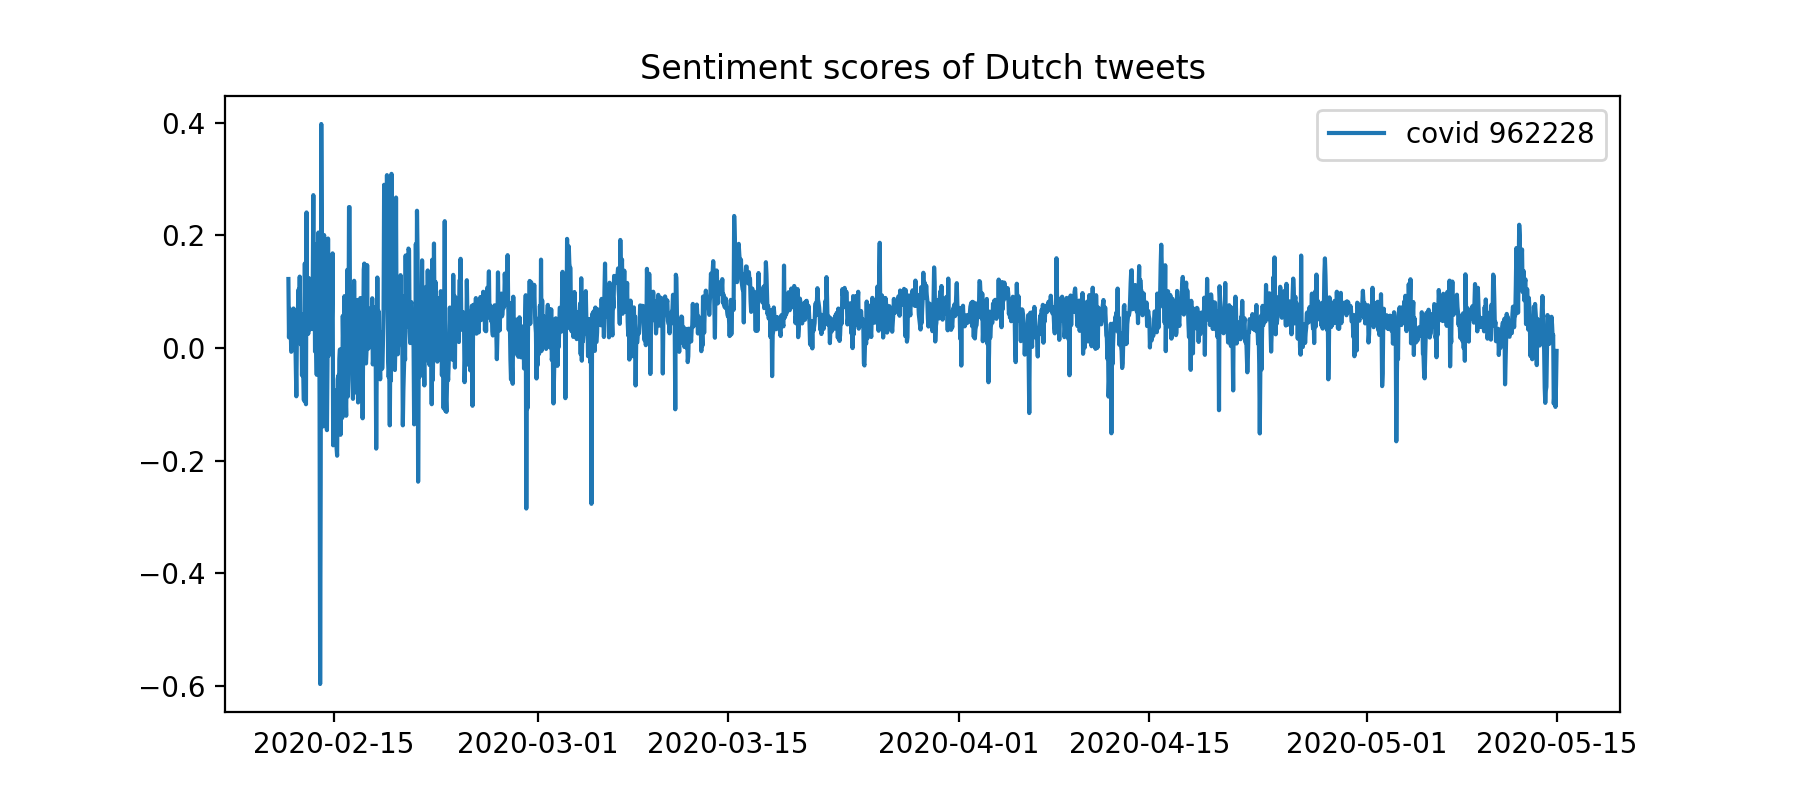

/home/erikt/anaconda3/envs/python37/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


In [7]:
dummy = visualizeSentiment([{DATA:sentimentPerHour,LABEL:QUERY+" "+\
                             str(sum([sentimentPerHour[key][COUNT] for key in sentimentPerHour]))}],\
                           title=DEFAULTTITLE)

In [8]:
writeSentiment(sentimentPerHour,"../data/sentiment/"+QUERY+".csv")

In [9]:
sentimentPerHour = readSentiment("../data/sentiment/"+QUERY+".csv")

In [10]:
averageSentiment(sentimentPerHour)

0.06630939595424866

In [11]:
INFILENAME = "20200518-12.out.gz"
df = pd.read_csv(DATADIRECTORYTEXT+INFILENAME,compression="gzip",index_col=IDSTR)

In [12]:
QUERY = "test"

tokens = {}
for key in df.index:
    for token in df.loc[key][0].split():
        if re.search(QUERY,token,flags=re.IGNORECASE):
            token = token.lower()
            if token in tokens: tokens[token] += 1
            else: tokens[token] = 1

In [13]:
{token:tokens[token] for token,count in sorted(tokens.items(),key=lambda item:item[1], reverse=True)}